In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Processing of Data Frame

In [3]:
df = pd.read_csv('../data/ford.csv')

In [4]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


In [5]:
df2 = df.drop(['model'], axis =1)

In [6]:
dummy_cols = ['transmission', 'fuelType']
df_dummies = pd.get_dummies(df2[dummy_cols], dtype=int)
df3 = pd.concat([df2, df_dummies], axis=1)
df3 = df3.drop(['transmission', 'fuelType'], axis =1)

In [7]:
for col in df3:
    if df3[col].isnull().sum() > 0:
        try:
            df3[col].fillna(df3[col].mean(), inplace = True)
        except:
            df3[col].fillna(df3[col].mode()[0],inplace = True)

In [8]:
df3 = df3.drop(columns=['fuelType_Electric', 'tax'])
df3

,year,price,mileage,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,12000,15944,57.7,1.0,1,0,0,0,0,0,1
1,2018,14000,9083,57.7,1.0,0,1,0,0,0,0,1
2,2017,13000,12456,57.7,1.0,0,1,0,0,0,0,1
3,2019,17500,10460,40.3,1.5,0,1,0,0,0,0,1
4,2019,16500,1482,48.7,1.0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17960,2016,7999,31348,54.3,1.2,0,1,0,0,0,0,1
17961,2017,8999,16700,47.1,1.4,0,1,0,0,0,0,1
17962,2014,7499,40700,57.7,1.0,0,1,0,0,0,0,1
17963,2015,9999,7010,67.3,1.6,0,1,0,1,0,0,0


### Creating Target Variable and Features and a basic Random Forest Model for reference

In [9]:
target_variable = 'price'
X = df3.drop(target_variable, axis =1)
# X = df4[['ApplicantIncome']]
y = df3['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8978876208919583

### RandomSearchCV used to Find best range of hyperparamters, step 1 in tuning 


In [112]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False]}


In [113]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [19]:
rf_random.best_params_

{'n_estimators': 600,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

### GridSearchCV to now tune the hyperparameters to best fit, step 2

In [26]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 100],
    'max_features': [2,3,4],
    'n_estimators': [100, 300,600, 800]
}
# Create a based model
rf = RandomForestRegressor()


In [27]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [28]:
grid_search.fit(X_train, y_train) # Fit the GridSearchCV on the training data

# Print the best parameters and best score found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 60, 'max_features': 8, 'n_estimators': 600}
Best score found:  0.9090723891034008


### Now adding the tuned hyperparamters to the Random Forest Model

In [15]:
final_model = RandomForestRegressor(bootstrap = True, max_depth = 30, max_features= 'sqrt', n_estimators= 800, oob_score= True)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, max_features='sqrt', n_estimators=600,
                      oob_score=True)

In [17]:
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.8994110105681007

In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse =mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print(final_model.oob_score_)

Mean Squared Error: 2255519.8167940406
Mean Absolute Error: 991.6899610937651
0.9077124749542133


### Visuals

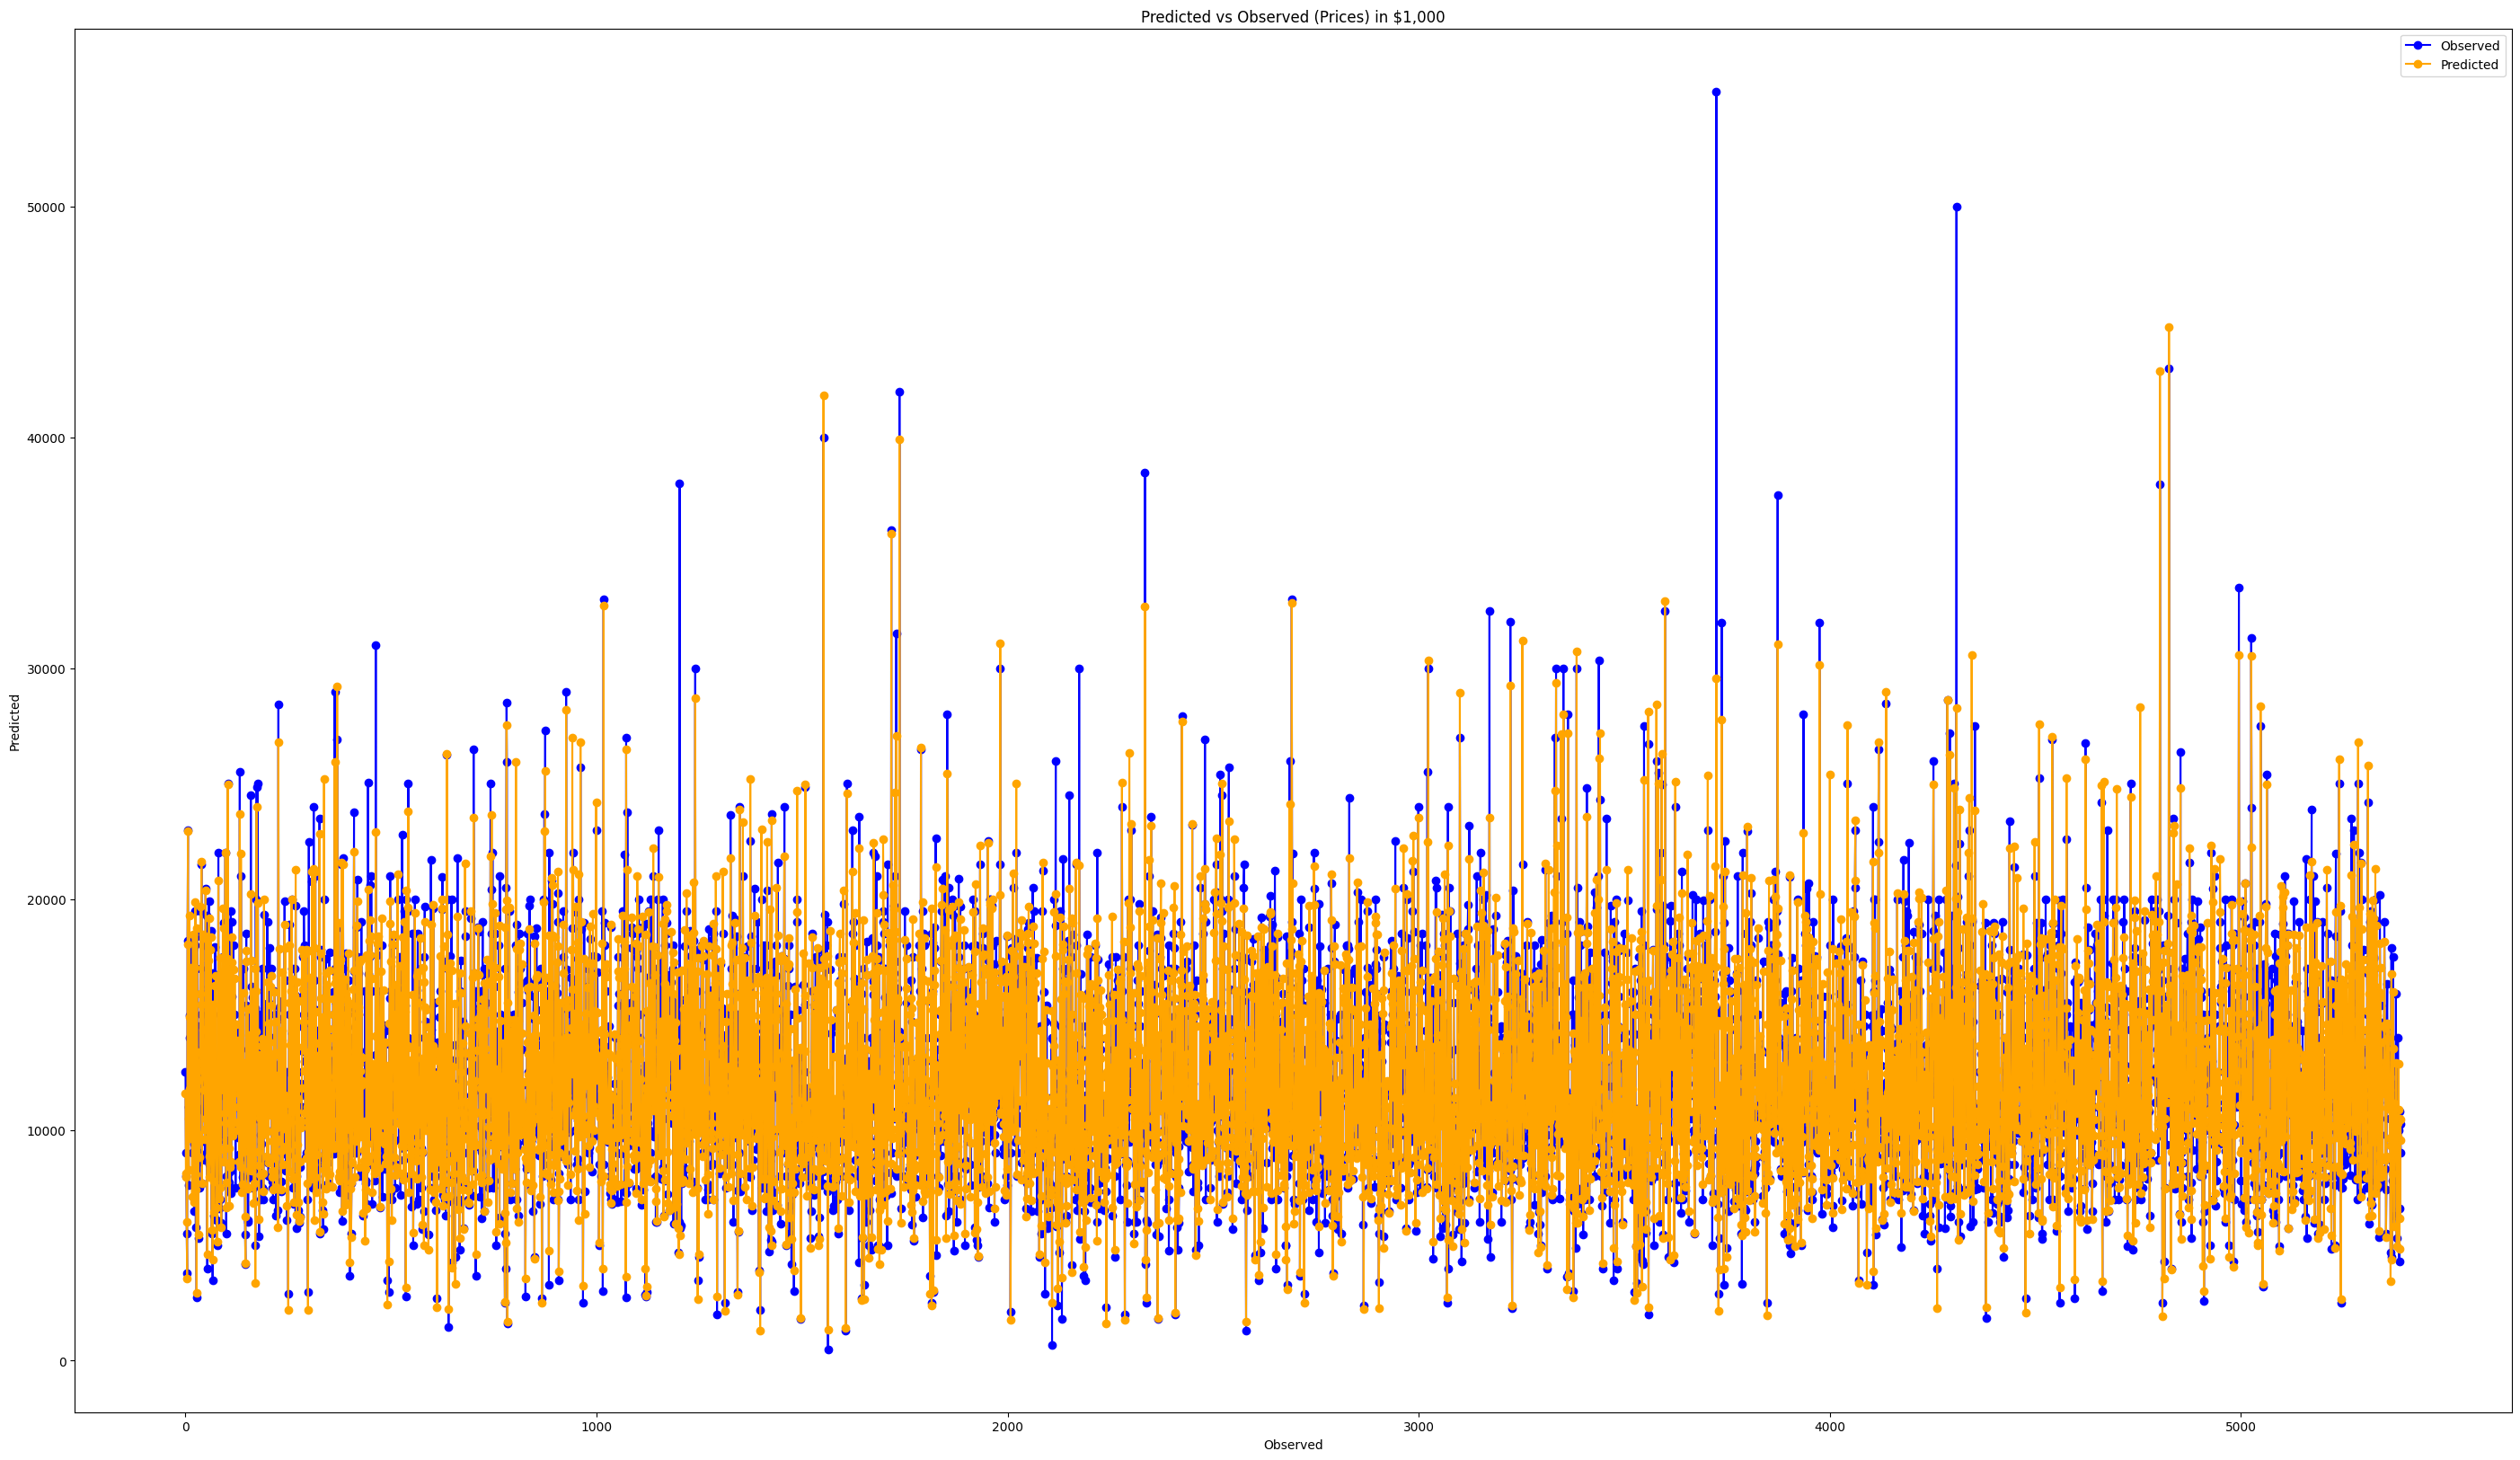

In [14]:
#setting boundaries and parameters
plt.rcParams['figure.figsize'] = (35,20)
x_ax = range(len(X_test))
# plt.plot( linestyle='--', marker='o', color='b', label='line with marker')

#plotting
plt.plot(x_ax,y_test,label='Observed',marker = 'o',color = 'blue',linestyle='-')
plt.plot(x_ax,y_pred,label='Predicted',marker = 'o',color = 'orange',linestyle='-')

#adding labeels
plt.title('Predicted vs Observed (Prices) in $1,000')
# Set x-axis label
plt.xlabel('Observed')
# Set y-axis label
plt.ylabel('Predicted')

plt.legend();
plt.show()

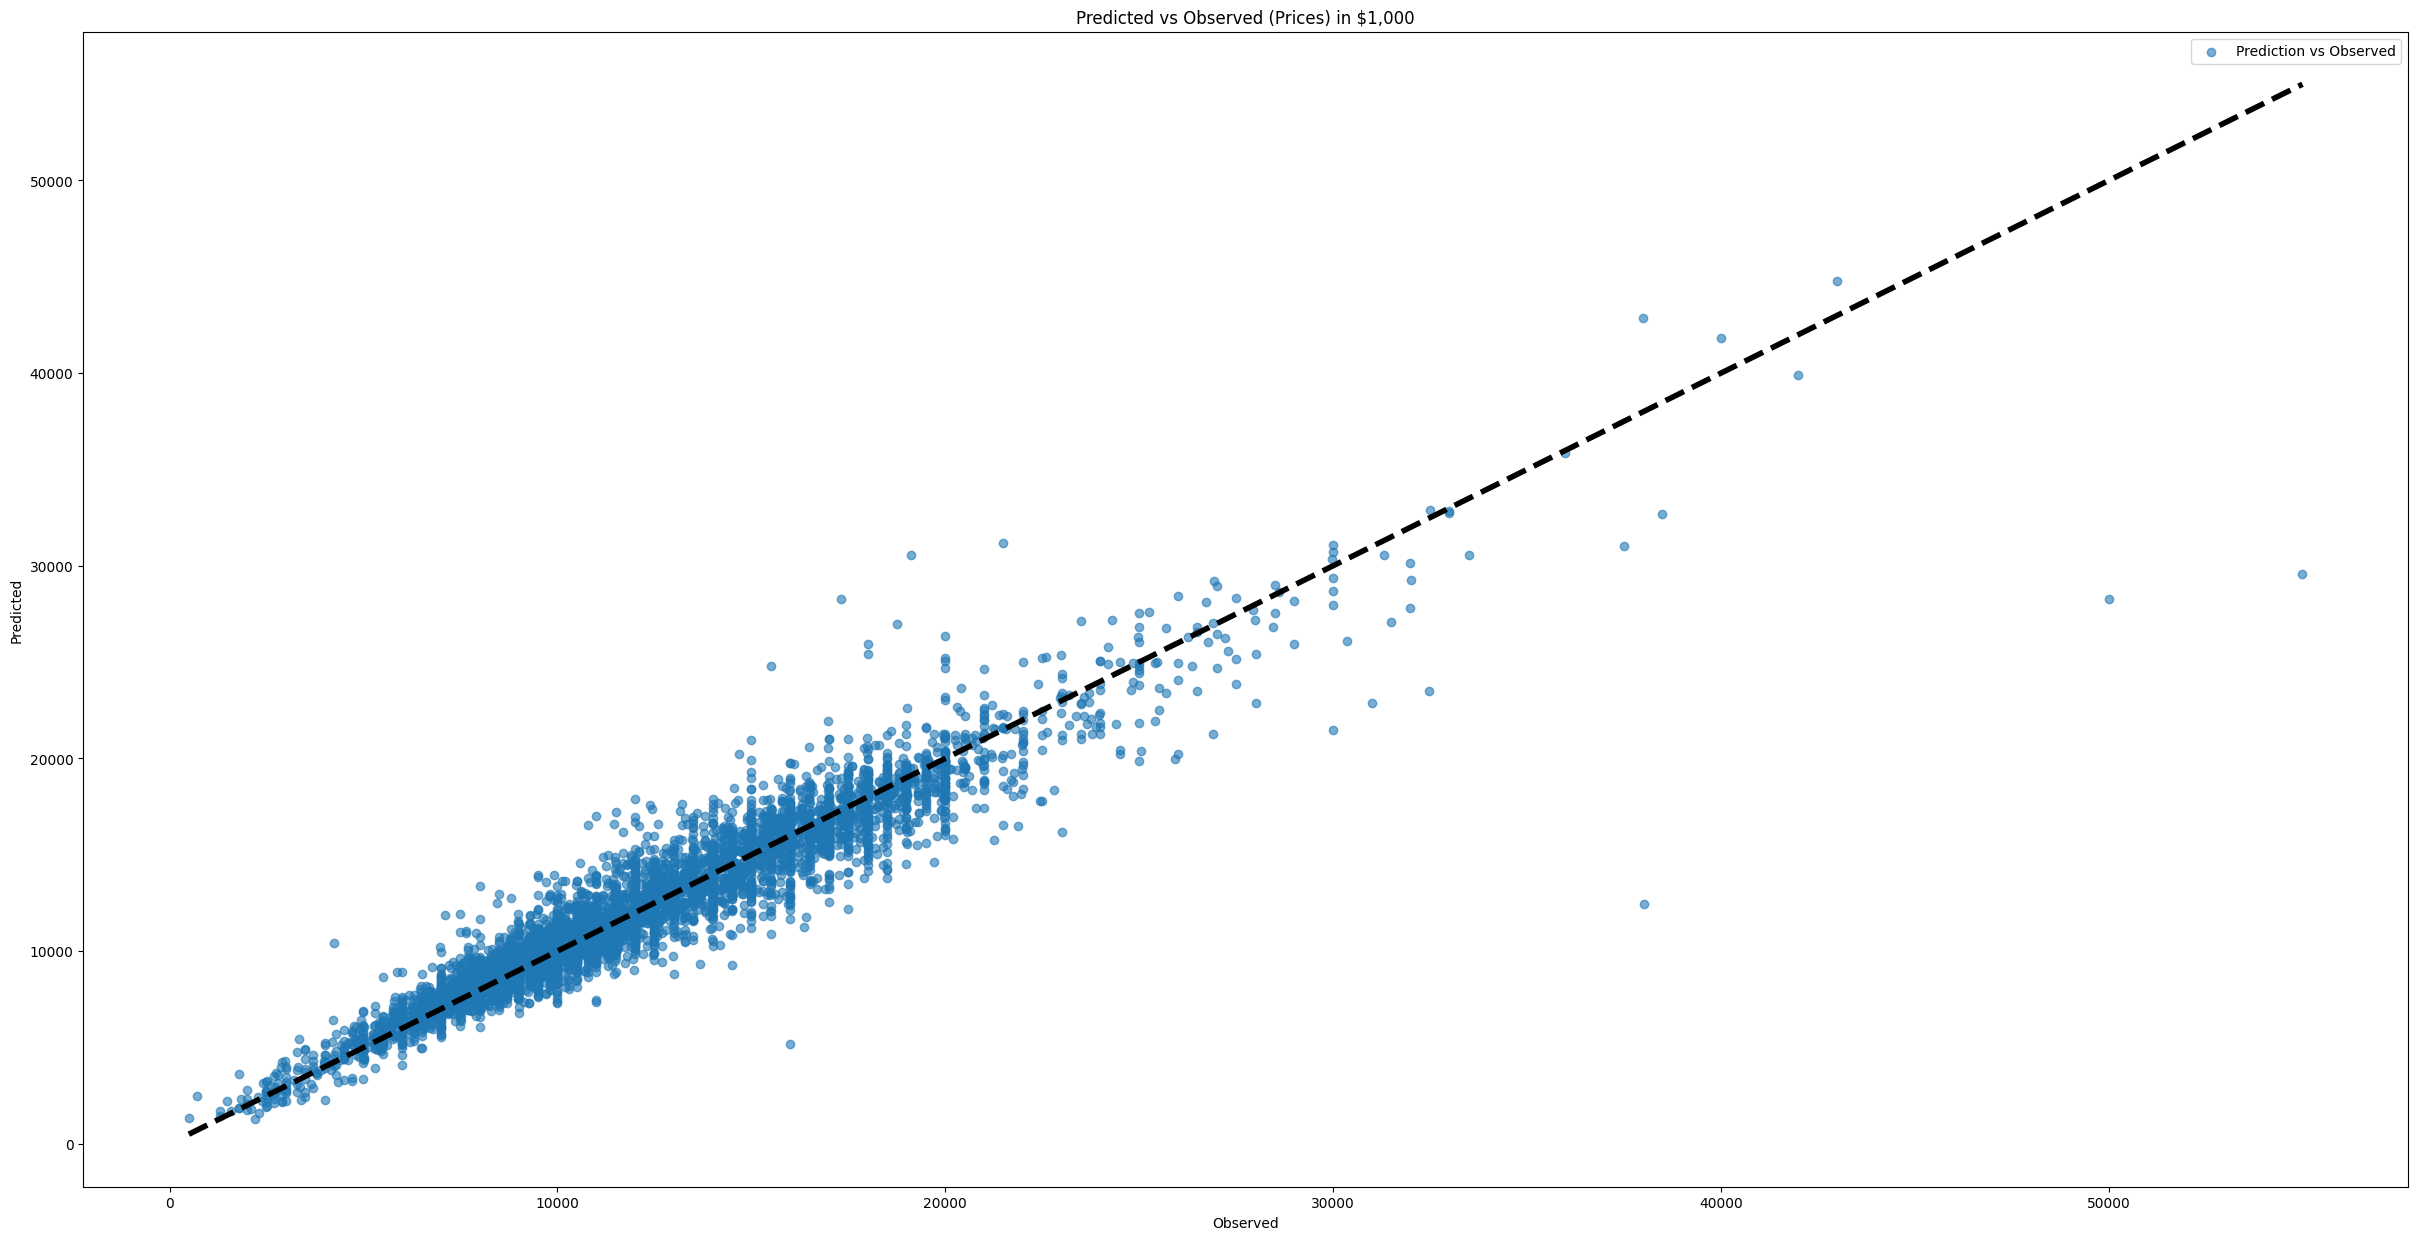

In [15]:
plt.rcParams['figure.figsize'] = (30,15)
plt.scatter(x = y_test, y = y_pred ,label='Prediction vs Observed',marker='o',alpha = 0.6)

# add a line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# adding labels
plt.title('Predicted vs Observed (Prices) in $1,000')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend()

plt.show()




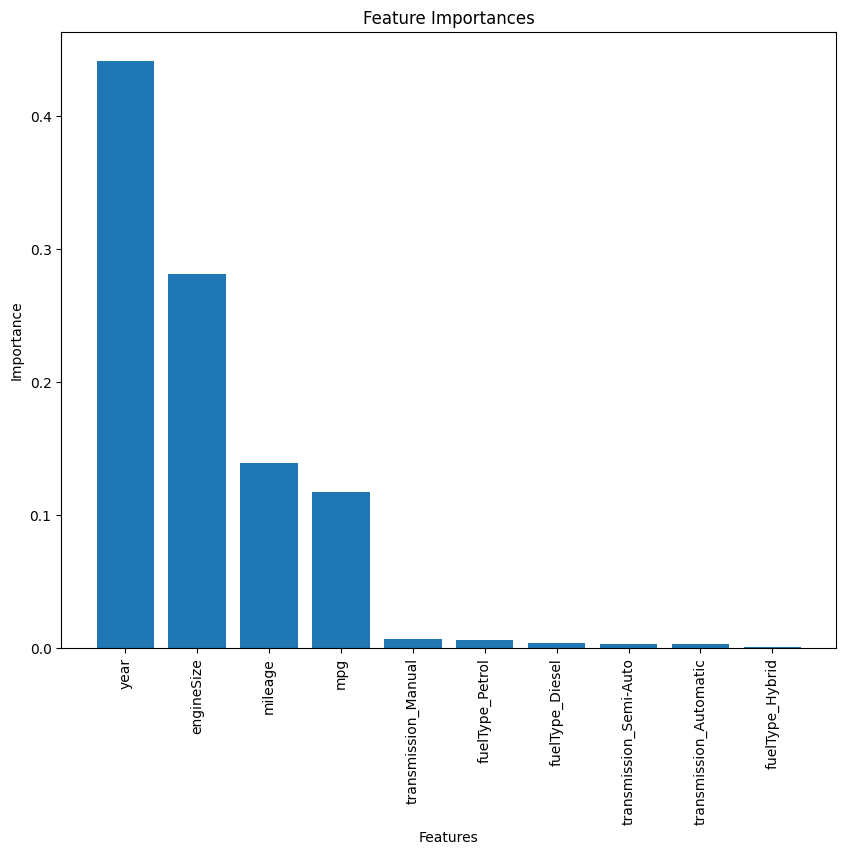

In [16]:
importances = final_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get the top 10 most important features
top_features = indices[:10]

# Plot the feature importances as a bar graph
plt.figure(figsize=(10,8))
plt.bar(range(10), importances[top_features])
plt.xticks(range(10), X.columns[top_features], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

### Now Bringing in a whole new data set to test the model

In [19]:
test_df = pd.read_csv('../data/hyundi.csv')
test_df.head(10)

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0
5,I10,2015,6149,Manual,41650,Petrol,20,60.1,1.0
6,I20,2015,6799,Manual,39547,Petrol,30,55.4,1.2
7,Tucson,2016,14199,Automatic,30300,Diesel,125,57.6,1.7
8,I30,2018,10399,Automatic,38082,Petrol,145,51.4,1.4
9,Tucson,2016,12163,Manual,21014,Diesel,30,61.7,1.7


In [20]:
test_df2 = test_df.drop(['model'], axis =1)

dummy_cols = ['transmission', 'fuelType']
df_dummies = pd.get_dummies(test_df2[dummy_cols], dtype=int)
test_df3 = pd.concat([test_df2, df_dummies], axis=1)
test_df3 = test_df3.drop(['transmission', 'fuelType'], axis =1)

for col in test_df3:
    if test_df3[col].isnull().sum() > 0:
        try:
            test_df3[col].fillna(df3[col].mean(), inplace = True)
        except:
            test_df3[col].fillna(df3[col].mode()[0],inplace = True)



In [21]:
test_df3 = test_df3.drop(columns=['tax(£)', 'transmission_Other'])
test_df3

,year,price,mileage,mpg,engineSize,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,7999,17307,58.9,1.2,0,1,0,0,0,0,1
1,2016,14499,25233,43.5,2.0,1,0,0,1,0,0,0
2,2016,11399,37877,61.7,1.7,0,1,0,1,0,0,0
3,2016,6499,23789,60.1,1.0,0,1,0,0,0,0,1
4,2015,10199,33177,51.4,2.0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4855,2016,8680,25906,78.4,1.6,0,1,0,1,0,0,0
4856,2015,7830,59508,65.7,1.7,0,1,0,1,0,0,0
4857,2017,6830,13810,60.1,1.0,0,1,0,0,0,0,1
4858,2018,13994,23313,44.8,1.6,0,1,0,0,0,0,1


### Applying it to the Model with tuned hyperparamters

In [22]:

target_variable = 'price'
X_2 = test_df3.drop(target_variable, axis =1)
# X = df4[['ApplicantIncome']]
y_2 = test_df3['price']

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.75, random_state=42)

In [31]:
y_pred2 = final_model.predict(X_test2)
r2 = r2_score(y_test2, y_pred2)
mae2 = mean_absolute_error(y_test2, y_pred2)
print('Mean Absolute Error:', mae2)
print('R2 score on new data:', r2)

Mean Absolute Error: 2441.4921135274626
R2 score on new data: 0.6575093964217662


In [25]:
x_ax = range(len(X_test2))
ax_2 = range(len(y_pred2))

x_ax, ax_2

(range(0, 1458), range(0, 1458))

### Visuals

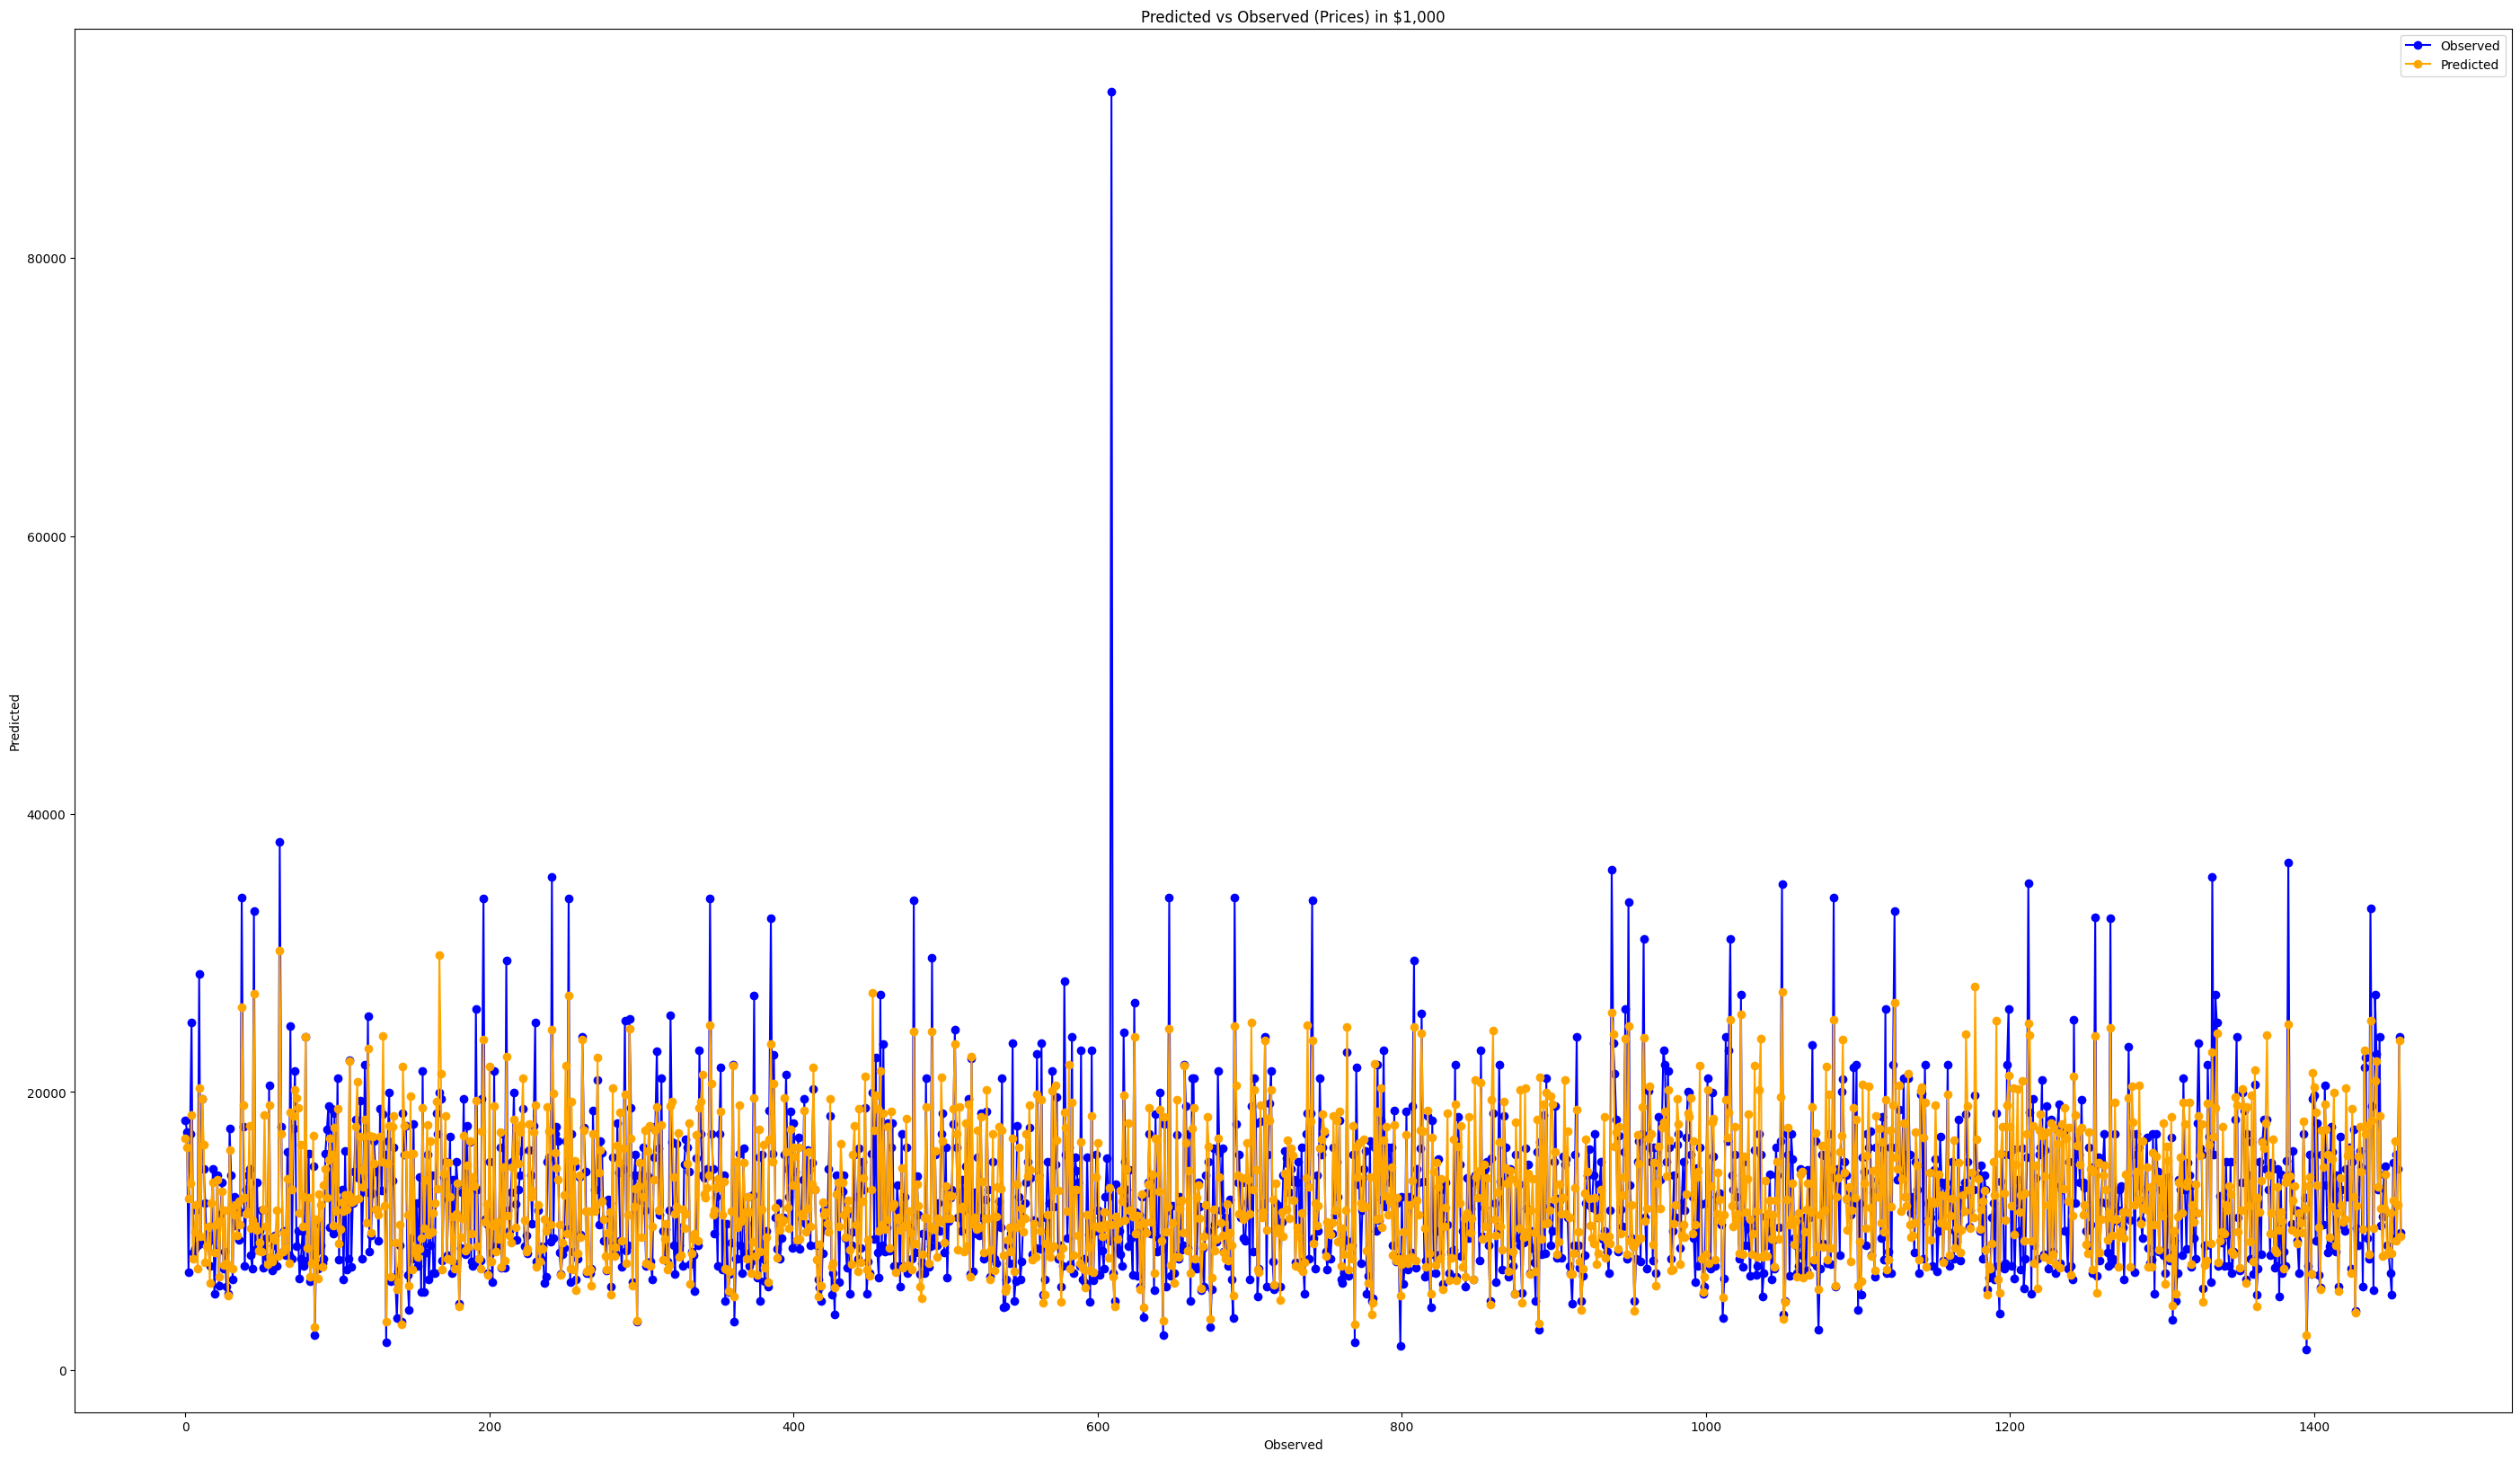

In [26]:
plt.rcParams['figure.figsize'] = (35,20)
x_ax = range(len(X_test2))

# Reshape y_pred2 to match the shape of y_test2
y_pred2 = y_pred2.reshape(y_test2.shape)

# Plotting
plt.plot(x_ax,y_test2,label='Observed',marker='o',color='blue',linestyle='-')
plt.plot(x_ax,y_pred2,label='Predicted',marker='o',color='orange',linestyle='-')

# Adding labels
plt.title('Predicted vs Observed (Prices) in $1,000')
plt.xlabel('Observed')
plt.ylabel('Predicted')

plt.legend()
plt.show()


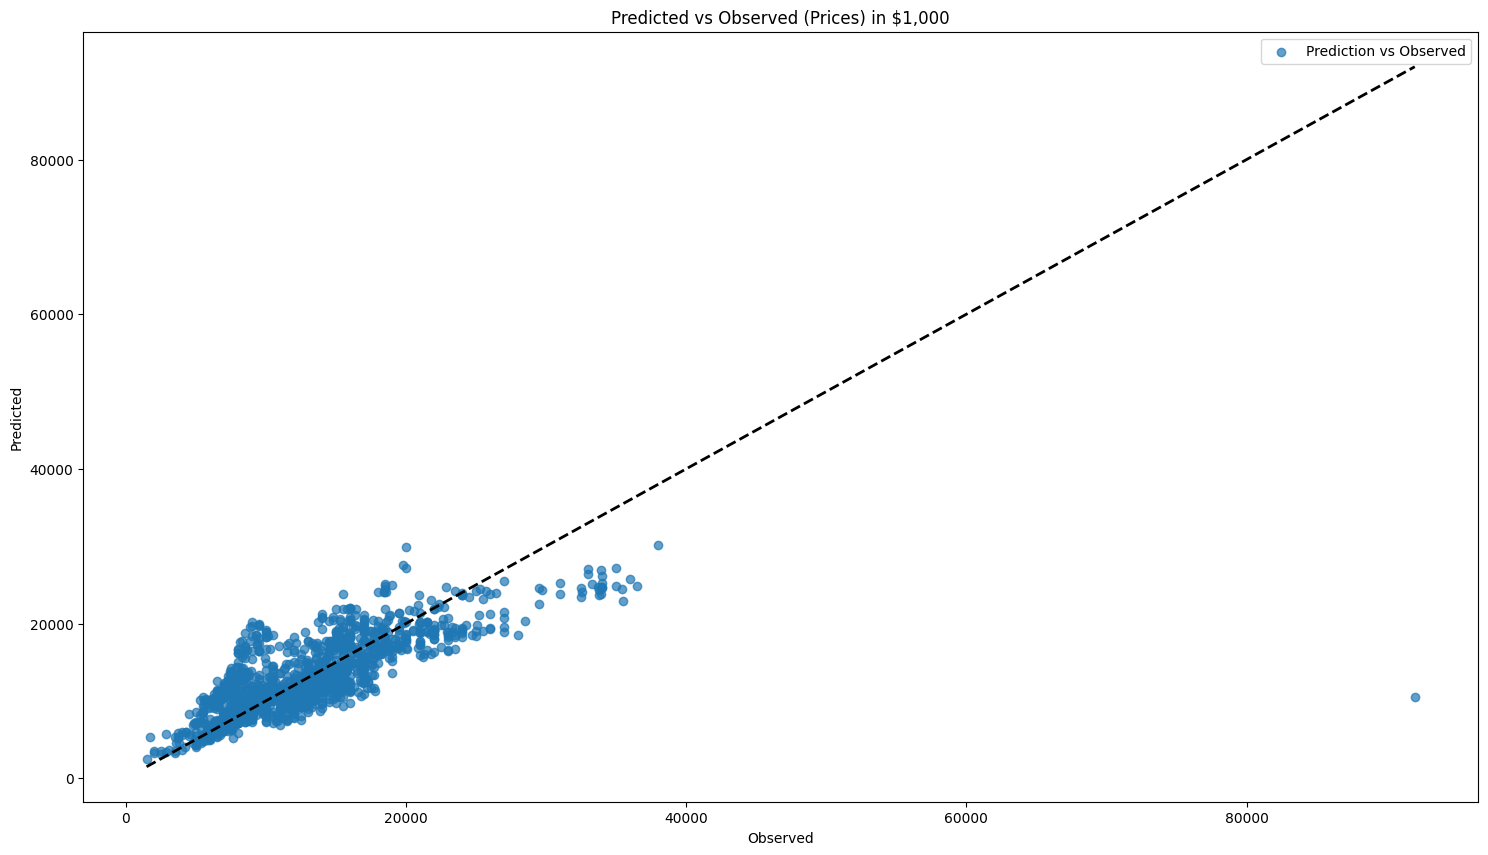

In [27]:
plt.rcParams['figure.figsize'] = (18,10)
plt.scatter(x = y_test2, y = y_pred2 ,label='Prediction vs Observed',marker='o',alpha = 0.7)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)

plt.title('Predicted vs Observed (Prices) in $1,000')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend()

plt.show()